# Carga, limpieza y análisis de los datos del tráfico diario

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dbfread import DBF
import geopandas as gpd
import datetime
import glob
import warnings
warnings.filterwarnings('ignore')

Se definen dos listas con las rutas hacia los ficheros con los datos del tráfico (identificador, nombre, intensidad...) y los puntos de medida:

In [2]:
path = "../Data_input/Historico datos trafico"
traffic_data_files = glob.glob(path + '/*.csv')
traffic_data_files

['../Data_input/Historico datos trafico\\01-2022.csv',
 '../Data_input/Historico datos trafico\\02-2022.csv',
 '../Data_input/Historico datos trafico\\03-2022.csv',
 '../Data_input/Historico datos trafico\\04-2022.csv',
 '../Data_input/Historico datos trafico\\05-2022.csv',
 '../Data_input/Historico datos trafico\\06-2022.csv',
 '../Data_input/Historico datos trafico\\07-2022.csv',
 '../Data_input/Historico datos trafico\\08-2022.csv',
 '../Data_input/Historico datos trafico\\09-2022.csv',
 '../Data_input/Historico datos trafico\\10-2022.csv',
 '../Data_input/Historico datos trafico\\11-2022.csv',
 '../Data_input/Historico datos trafico\\12-2022.csv']

In [3]:
path_datos = "../Data_input/Historico puntos trafico"
traffic_points_files = glob.glob(path_datos + '/*.csv')
traffic_points_files

['../Data_input/Historico puntos trafico\\pmed_ubicacion_01-2022.csv',
 '../Data_input/Historico puntos trafico\\pmed_ubicacion_02-2022.csv',
 '../Data_input/Historico puntos trafico\\pmed_ubicacion_03-2022.csv',
 '../Data_input/Historico puntos trafico\\pmed_ubicacion_04-2022.csv',
 '../Data_input/Historico puntos trafico\\pmed_ubicacion_05-2022.csv',
 '../Data_input/Historico puntos trafico\\pmed_ubicacion_06-2022.csv',
 '../Data_input/Historico puntos trafico\\pmed_ubicacion_07-2022.csv',
 '../Data_input/Historico puntos trafico\\pmed_ubicacion_08-2022.csv',
 '../Data_input/Historico puntos trafico\\pmed_ubicacion_09-2022.csv',
 '../Data_input/Historico puntos trafico\\pmed_ubicacion_10-2022.csv',
 '../Data_input/Historico puntos trafico\\pmed_ubicacion_11-2022.csv',
 '../Data_input/Historico puntos trafico\\pmed_ubicacion_12-2022.csv']

Las variables globales que se usan en la ejecución de las funciones son las siguientes:

In [4]:
meses = list(range(1, 13))

horas_dia = [6,7,8,9,10,11,12,13,14,15,16,17]
horas_tarde = [18,19,20,21]
horas_noche = [22,23,0,1,2,3,4,5]

vehiculos_pesados = 0.0862
vehiculos_ligeros = 1 - vehiculos_pesados

crs = "EPSG:25830"

### Preprocesamiento

A continuación se definen dos funciones para llevar a cabo la imputación de los datos para un mes: la primera según el el punto de medida y el día de la semana, y la segunda según el día de la semana únicamente.

In [5]:
def imputacion_media_dia_semana(fichero_transformado, mes):
    """
    Imputación de la media de las intensidades existentes según el día de la semana
    para cada punto de medida.
    
    Parámetros de entrada:
    - fichero_transformado: fichero transformado de un mes con los datos del tráfico
    
    Devuelve:
    - Fichero transformado con todos los registros completos
    """
    
    # Se calculan las medias de día, tarde y noche de todo el mes para cada ID 
    # y día de la semana
    medias_dia = fichero_transformado.groupby(['id', 'dia_semana'])['Dia'].mean()
    medias_tarde = fichero_transformado.groupby(['id', 'dia_semana'])['Tarde'].mean()
    medias_noche = fichero_transformado.groupby(['id', 'dia_semana'])['Noche'].mean()

    valor_maximo = fichero_transformado['dia'].nunique()
    dia_anterior = 0
    lista_filas = []
    for index, ident, dia_mes, dia, tarde, noche, dia_semana in zip(range(len(fichero_transformado)),
                                                                    fichero_transformado['id'],
                                                                    fichero_transformado['dia'],
                                                                    fichero_transformado['Dia'],
                                                                    fichero_transformado['Tarde'],
                                                                    fichero_transformado['Noche'],
                                                                    fichero_transformado['dia_semana']):
        if dia_mes-1 != dia_anterior:
            if dia_anterior != valor_maximo:

                if dia_mes < dia_anterior:
                    for i in range(dia_anterior+1, valor_maximo+1):
                        fecha_nueva = datetime.datetime(year=2022, month=mes, day=i)
                        dia_sem_nuevo = fecha_nueva.weekday()
                        fila_nueva = [fichero_transformado['id'][index-1], i,
                                      medias_dia[ident_anterior, dia_sem_nuevo],
                                      medias_tarde[ident_anterior, dia_sem_nuevo],
                                      medias_noche[ident_anterior, dia_sem_nuevo],
                                      fecha_nueva, dia_sem_nuevo]
                        lista_filas.append(fila_nueva)
                    for i in range(1, dia_mes):
                        fecha_nueva = datetime.datetime(year=2022, month=mes, day=i)
                        dia_sem_nuevo = fecha_nueva.weekday()
                        fila_nueva = [ident, i, medias_dia[ident, dia_sem_nuevo],
                                      medias_tarde[ident, dia_sem_nuevo],
                                      medias_noche[ident, dia_sem_nuevo],
                                      fecha_nueva, dia_sem_nuevo]
                        lista_filas.append(fila_nueva)

                if dia_mes > dia_anterior:
                    for i in range(dia_anterior+1, dia_mes):
                        fecha_nueva = datetime.datetime(year=2022, month=mes, day=i)
                        dia_sem_nuevo = fecha_nueva.weekday()
                        fila_nueva = [ident, i, medias_dia[ident, dia_sem_nuevo],
                                      medias_tarde[ident, dia_sem_nuevo], medias_noche[ident, dia_sem_nuevo],
                                      fecha_nueva, dia_sem_nuevo]
                        lista_filas.append(fila_nueva)

            if dia_anterior == valor_maximo & dia_mes != 1:
                for j in range(1, dia_mes):
                    fecha_nueva = datetime.datetime(year=2022, month=mes, day=j)
                    dia_sem_nuevo = fecha_nueva.weekday()
                    fila_nueva = [ident, j, medias_dia[ident, dia_sem_nuevo],
                                  medias_tarde[ident, dia_sem_nuevo], medias_noche[ident, dia_sem_nuevo],
                                  fecha_nueva, dia_sem_nuevo]
                    lista_filas.append(fila_nueva)

        if np.isnan(dia):
            fichero_transformado['Dia'][index] = medias_dia[ident, dia_semana]
        if np.isnan(tarde):
            fichero_transformado['Tarde'][index] = medias_tarde[ident, dia_semana]
        if np.isnan(noche):
            fichero_transformado['Noche'][index] = medias_noche[ident, dia_semana]

        dia_anterior = dia_mes
        ident_anterior = ident
        if dia_mes == valor_maximo:
            dia_anterior = 0
    
    # Dataframe de nuevos registros con las medias
    df_filas_nuevas = pd.DataFrame(lista_filas, columns=fichero_transformado.columns)
    
    # Dataframe completo con todos los días para todas las ID
    traffic_mes1_7 = pd.concat([fichero_transformado, df_filas_nuevas])
    traffic_mes1_7.reset_index(drop=True, inplace=True)

    return traffic_mes1_7

In [6]:
def imputacion_media_total(fichero_transformado):
    """
    Imputación de la media de las intensidades existentes para cada punto de medida.
    
    Parámetros de entrada:
    - fichero_transformado: fichero transformado de un mes con los datos del tráfico
    
    Devuelve:
    - Fichero transformado con todos los registros completos
    """
    
    # Se calculan las medias de día, tarde y noche de todo el mes para cada ID
    medias_dia_total = fichero_transformado.groupby("id")['Dia'].mean()
    medias_tarde_total = fichero_transformado.groupby("id")['Tarde'].mean()
    medias_noche_total = fichero_transformado.groupby("id")['Noche'].mean()
    
    index_nulls = np.where(fichero_transformado.isnull())[0]
    rows_nulls = fichero_transformado.loc[index_nulls]

    for index, ident, dia, tarde, noche in zip(rows_nulls.index,
                                               rows_nulls['id'],
                                               rows_nulls['Dia'],
                                               rows_nulls['Tarde'],
                                               rows_nulls['Noche']):
        if np.isnan(dia):
            fichero_transformado['Dia'][index] = medias_dia_total[ident]
        if np.isnan(tarde):
            fichero_transformado['Tarde'][index] = medias_tarde_total[ident]
        if np.isnan(noche):
            fichero_transformado['Noche'][index] = medias_noche_total[ident]
    
    return fichero_transformado

In [7]:
def transformacion_trafico_diario(fichero_intensidad, fichero_puntos, mes):
    """
    Esta función procesa los datos de los ficheros para obtener la intensidad
    del tráfico en cada punto de medida para cada día del mes.
    
    Parámetros de entrada:
    - fichero_intensidad: fichero de un mes con los datos del tráfico
    - fichero_puntos: fichero de un mes de los puntos de medida
    - mes: mes (entero)
    
    Devuelve:
    - Geodataset con las intensidades de tráfico en cada punto de medida
    para los tres periodos del día y para cada día del mes.
    """
    # Lectura del fichero
    traffic_mes = pd.read_csv(fichero_intensidad, sep=";")
    
    traffic_mes = traffic_mes[['id', 'fecha', 'tipo_elem', 'intensidad']]
    
    # Se eliminan los id con valores únicos de intensidad < 30
    traffic_mes_2 = traffic_mes[traffic_mes
                                  .groupby('id')['intensidad']
                                  .transform('nunique') >= 30]
    
    # Se transforma el tipo de la columna fecha
    traffic_mes_2['fecha'] = pd.to_datetime(traffic_mes_2['fecha'])
    # Se crean los atributos: mes, dia, hora
    traffic_mes_2["mes"] = traffic_mes_2["fecha"].dt.month
    traffic_mes_2["dia"] = traffic_mes_2["fecha"].dt.day
    traffic_mes_2["hora"] = traffic_mes_2["fecha"].dt.hour
    
    # Se eliminan los id con valores únicos de día < 25
    traffic_mes_3 = traffic_mes_2[traffic_mes_2
                                    .groupby('id')['dia']
                                    .transform('nunique')>=25]
    
    # Se crea la variable periodo_dia con los posibles valores: Dia, Tarde, Noche
    periodo_dia_lista = []
    for hora in traffic_mes_3['hora']:
        if hora in horas_dia:
            periodo_dia_lista.append('Dia')
        elif hora in horas_tarde:
            periodo_dia_lista.append('Tarde')
        else:
            periodo_dia_lista.append('Noche')

    traffic_mes_3['periodo_dia'] = periodo_dia_lista
    
    # Se agrupan los id por el periodo del día para eliminar aquellos id que tengan...
    # menos de una cuarta parte del total de veces que tendría que aparecer...
    # (un dato de tráfico cada 15 minutos)
    periodo_dia_agrupado_cont = traffic_mes_3.groupby(['id'])['periodo_dia'].value_counts()
    periodo_dia_agrupado_cont_df = periodo_dia_agrupado_cont.to_frame().reset_index()
    
    dia = periodo_dia_agrupado_cont_df[periodo_dia_agrupado_cont_df['periodo_dia']=='Dia']
    dia2 = dia[dia['count']<(1488/4)]

    tarde = periodo_dia_agrupado_cont_df[periodo_dia_agrupado_cont_df['periodo_dia']=='Tarde']
    tarde2 = tarde[tarde['count']<(496/4)]

    noche = periodo_dia_agrupado_cont_df[periodo_dia_agrupado_cont_df['periodo_dia']=='Noche']
    noche2 = noche[noche['count']<(992/4)]
    
    dia_tarde_noche = dia2.merge(tarde2, on="id", how="outer").merge(noche2, on="id", how="outer")
    
    traffic_mes_4 = traffic_mes_3[~traffic_mes_3.id.isin(dia_tarde_noche['id'])]

    # Se agrupan las intensidades por id, día del mes y periodo del día
    traffic_mes1_5 = traffic_mes_4.groupby(['id', 'dia', 'periodo_dia'])['intensidad'].mean()
    traffic_mes1_5 = traffic_mes1_5.to_frame().reset_index()
    
    # Se pivota para obtener tres columnas según el periodo del día
    traffic_mes1_6 = traffic_mes1_5.pivot(index=["id","dia"], columns="periodo_dia", values="intensidad").reset_index()
    traffic_mes1_6 = traffic_mes1_6.rename_axis(None, axis=1)
    
    # Se otiene la fecha y el día de la semana para hacer la imputación de datos
    traffic_mes1_6['Fecha'] = pd.to_datetime(dict(year=2022, month=mes, day=traffic_mes1_6['dia']))
    traffic_mes1_6['dia_semana'] = traffic_mes1_6['Fecha'].dt.dayofweek
    
    # Imputación de valores por el día de la semana
    traffic_imputation = imputacion_media_dia_semana(traffic_mes1_6, mes)
    
    # Hay algún caso que siguen habiendo valores nulos porque no tienen los mismos días
    # de la semana con datos. Por eso se hace la imputación por la media total de ese ID
    if traffic_imputation.isnull().values.any() == True:
        traffic_imputation = imputacion_media_total(traffic_imputation)
    
    traffic_imputation['month'] = mes
    traffic_imputation['year'] = 2022
    
    # Atributos para la intensidad de vehículos ligeros
    traffic_imputation['dia_lig'] = np.ceil(traffic_imputation['Dia'] * vehiculos_ligeros).astype(int)
    traffic_imputation['tarde_lig'] = np.ceil(traffic_imputation['Tarde'] * vehiculos_ligeros).astype(int)
    traffic_imputation['noche_lig'] = np.ceil(traffic_imputation['Noche'] * vehiculos_ligeros).astype(int)

    # Atributos para la intensidad de vehículos pesados
    traffic_imputation['dia_pes'] = np.ceil(traffic_imputation['Dia'] * vehiculos_pesados).astype(int)
    traffic_imputation['tarde_pes'] = np.ceil(traffic_imputation['Tarde'] * vehiculos_pesados).astype(int)
    traffic_imputation['noche_pes'] = np.ceil(traffic_imputation['Noche'] * vehiculos_pesados).astype(int)

    traffic_imputation['Dia'] = np.ceil(traffic_imputation['Dia']).astype(int)
    traffic_imputation['Tarde'] = np.ceil(traffic_imputation['Tarde']).astype(int)
    traffic_imputation['Noche'] = np.ceil(traffic_imputation['Noche']).astype(int)
    
    
    # Lectura del fichero de puntos
    points_mes = pd.read_csv(fichero_puntos, sep=';')
    
    # Se unen los dos ficheros
    traffic_data_points_mes = points_mes.merge(traffic_imputation, on="id", how="inner")

    # Se crea el atributo geometry que son puntos
    geo_traffic = gpd.GeoDataFrame(traffic_data_points_mes,
                                   geometry=gpd.points_from_xy(traffic_data_points_mes.utm_x,
                                                               traffic_data_points_mes.utm_y))
    geo_traffic.crs = "EPSG:25830"
    
    # Renombrar variables
    geo_traffic.rename(columns={'dia':'day',
                                'Dia':'int_dia',
                                'Tarde':'int_tarde',
                                'Noche':'int_noche'}, inplace=True)
    geo_traffic.drop('cod_cent', axis=1, inplace=True)
    
    return geo_traffic

In [8]:
def ejecucion_archivos_diarios(traffic_data_files, traffic_points_files, meses):
    """
    Se ejecuta las función anteriores para las dos listas definidas al inicio del notebook
    para concatenar todos los datos transformados.
    
    Parámetros de entrada:
    - traffic_data_files: lista de fichero con los datos del tráfico
    - traffic_points_files: lista de ficheros con los puntos de medida
    - meses: lista de meses en número
    
    Devuelve:
    - Dataset con los conjuntos de datos del tráfico diario concatenados.
    """
    lista_trafico_diario = []
    for traffic, points, mes in zip(traffic_data_files, traffic_points_files, meses):
        trafico_diario = transformacion_trafico_diario(traffic, points, mes)
        lista_trafico_diario.append(trafico_diario)
    dataset_trafico_diario = pd.concat(lista_trafico_diario, ignore_index = True)
    return dataset_trafico_diario

In [9]:
dataset_trafico_diario = ejecucion_archivos_diarios(traffic_data_files, traffic_points_files, meses)

In [84]:
print('Longitud del dataset:', len(dataset_trafico_diario))

Longitud del dataset: 1484655


Igual que con los datos de tráfico mensual, se asignan los códigos de los distritos a los puntos de medida de les falta.

In [33]:
ids_distrito5 = ((dataset_trafico_diario['id'] == 5462) |
                 (dataset_trafico_diario['id'] == 5463) |
                 (dataset_trafico_diario['id'] == 5512))
ids_distrito9 = ((dataset_trafico_diario['id'] == 6637) |
                 (dataset_trafico_diario['id'] == 3835))

dataset_trafico_diario.loc[ids_distrito5,'distrito'] = dataset_trafico_diario.loc[ids_distrito5,'distrito'].fillna(5)
dataset_trafico_diario.loc[ids_distrito9,'distrito'] = dataset_trafico_diario.loc[ids_distrito9,'distrito'].fillna(9)

In [34]:
dataset_trafico_diario['distrito'] = dataset_trafico_diario['distrito'].astype(int)

In [40]:
dataset_trafico_diario.rename(columns={'Fecha':'fecha'}, inplace=True)

In [86]:
dataset_trafico_diario.iloc[:5, :11]

,tipo_elem,distrito,id,nombre,utm_x,utm_y,longitud,latitud,day,int_dia,int_noche
0,URB,4,3840,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,1,57,32
1,URB,4,3840,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,2,96,27
2,URB,4,3840,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,3,174,32
3,URB,4,3840,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,4,182,34
4,URB,4,3840,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,5,158,26


In [87]:
dataset_trafico_diario.iloc[:5, 11:]

,int_tarde,fecha,dia_semana,month,year,dia_lig,tarde_lig,noche_lig,dia_pes,tarde_pes,noche_pes,geometry
0,94,2022-01-01,5,1,2022,52,86,29,5,9,3,POINT (441615.343 4475767.942)
1,140,2022-01-02,6,1,2022,88,128,25,9,13,3,POINT (441615.343 4475767.942)
2,187,2022-01-03,0,1,2022,159,171,30,15,17,3,POINT (441615.343 4475767.942)
3,234,2022-01-04,1,1,2022,166,214,31,16,21,3,POINT (441615.343 4475767.942)
4,71,2022-01-05,2,1,2022,144,65,24,14,7,3,POINT (441615.343 4475767.942)


Se exporta a un fichero .csv.

In [88]:
#dataset_trafico_diario_csv = dataset_trafico_diario.to_csv("../Data_output/trafico_diario.csv", index=False)

### Anáisis

**Días de la semana**

En esta parte se creará un gráfico que incluya cuatro variables: el mes, el día de la semana, el periodo del día y los valores de intensidad. Para ello, primero se agrupan los datos de la siguiente manera:

In [73]:
df_semanas = dataset_trafico_diario.groupby(['month', 'dia_semana'])[['int_dia', 'int_tarde', 'int_noche']].mean()
df_semanas = df_semanas.reset_index()
df_semanas

,month,dia_semana,int_dia,int_tarde,int_noche
0,1,0,515.462007,517.548524,103.751358
1,1,1,513.856316,521.416352,95.249469
2,1,2,524.089492,520.580283,101.197226
3,1,3,474.272314,511.617237,111.112987
4,1,4,521.203247,542.388902,133.602774
...,...,...,...,...,...
79,12,2,506.092923,544.255766,127.397730
80,12,3,481.713668,531.471134,140.393154
81,12,4,513.492061,529.387084,155.119738
82,12,5,342.518864,436.255110,166.074775


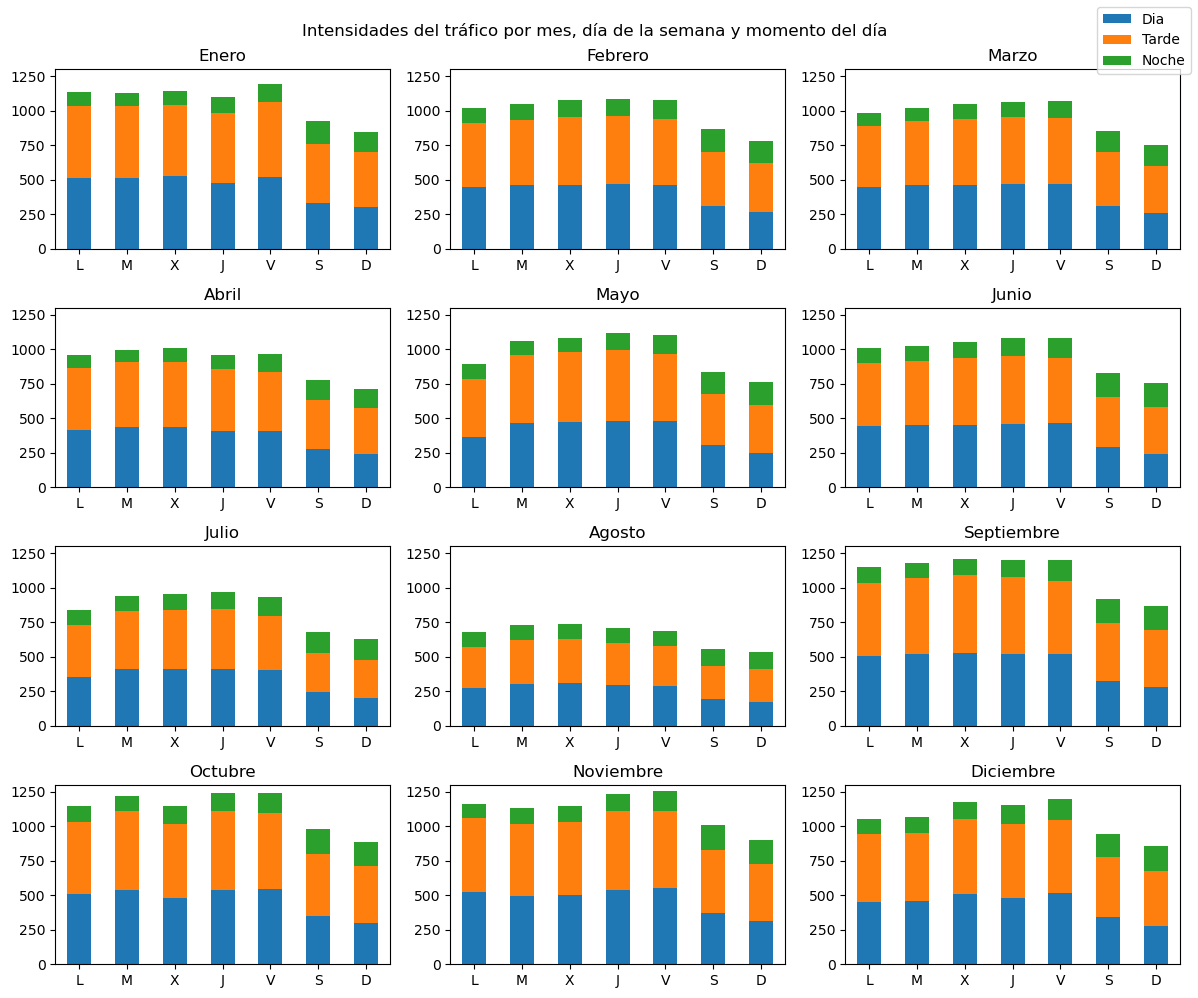

In [83]:
num_types = len(df_semanas["month"].unique())
fig, axes = plt.subplots(figsize=(12,10), nrows=4, ncols=3)
fig.suptitle("Intensidades del tráfico por mes, día de la semana y momento del día")
meses = ['Enero','Febrero', 'Marzo', 'Abril','Mayo','Junio','Julio',
         'Agosto','Septiembre','Octubre','Noviembre','Diciembre']
dias_labels = ['L','M','X','J','V','S','D']
# se aplanan los ejes
ax = axes.flatten()

# se itera sobre los grupos
for index, (mes, grupo) in enumerate(df_semanas.groupby("month")):
    grupo[["int_dia",'int_tarde','int_noche']].plot(kind="bar", stacked=True, ax=ax[index],
                                                    rot=0, title=meses[index], xlabel='')
    ax[index].set_ylim([0, 1300])
    ax[index].set_xticks(ticks=np.unique(grupo['dia_semana']),
                         labels=dias_labels)
    ax[index].get_legend().remove()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, ['Dia', 'Tarde', 'Noche'], ncols = 1, loc="upper right")

plt.tight_layout()
#plt.savefig('../Capturas/subplots_12.png', bbox_inches='tight')
plt.show()